                                                                                1. Low pass Gaussian filter

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

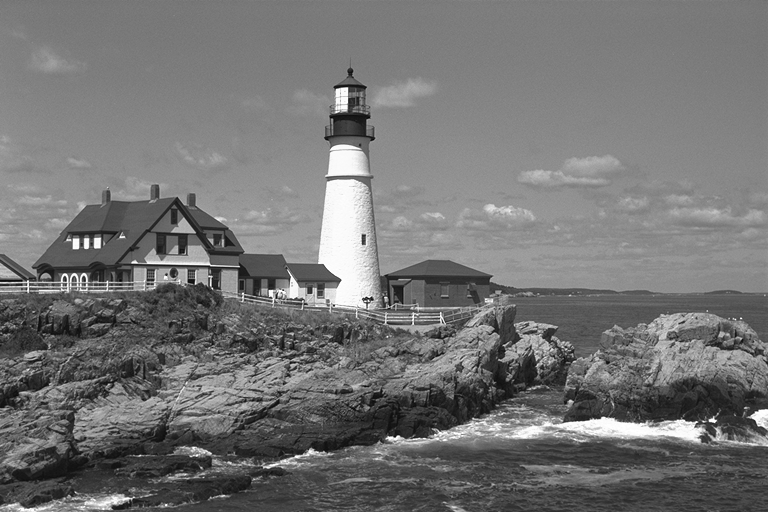

In [22]:
Image_path='lighthouse2.bmp'
X=Image.open(Image_path).convert('L')
X

In [23]:
X=np.array(X)
X.shape

(512, 768)

In [24]:
X

array([[118, 115, 115, ..., 109, 114, 115],
       [118, 120, 119, ..., 117, 115, 120],
       [124, 118, 119, ..., 117, 117, 120],
       ...,
       [121, 115, 137, ...,  57,  52,  54],
       [116, 116, 130, ...,  50,  47,  51],
       [167, 141, 119, ...,  59,  61,  65]], dtype=uint8)

In [25]:
Z=np.random.normal(0,10,X.shape)

In [26]:
Y=X+Z

In [27]:
Y=np.clip(Y,0,255)

In [28]:
def std(Y):
    Y_cpy=Y.copy()
    flat_Y=Y_cpy.flatten()
    mean_Y=np.mean(flat_Y)
    diff_from_mean=flat_Y-mean_Y
    sqd_diff=diff_from_mean**2
    sigma_sq_Y=np.mean(sqd_diff)
    return sigma_sq_Y
    

In [29]:
def calculate_coeffi(gaussian_filter):
    n=gaussian_filter.shape[0]
    center_element=gaussian_filter[n//2, n//2]
    sum_squared_val=np.sum([(gaussian_filter[i,j]**2)for i in range(n) for j in range(n) if (i,j)!=(n//2, n//2)])
    return (((1-center_element)**2) +sum_squared_val)
    

In [30]:
def gaussian_filter(size,sigma):
    x, y=np.mgrid[-size//2 + 1:size//2 + 1,-size//2 + 1:size//2+ 1]
    g=np.exp(-0.5*((x**2 + y**2)/sigma**2))
    return g/g.sum()

In [31]:
def apply_gaussian_filter(image, filter_size, sigma):
    gaussian = gaussian_filter(filter_size, sigma)
    return np.convolve(image.flatten(), gaussian.flatten(), mode='same').reshape(image.shape)


In [32]:
filter_sizes = [3, 7, 11]
sigmas = [0.1, 1, 2, 4, 8]

mse_sigma = []
mse_filter = []

best_filter = None
best_mse = float('inf')
denoised_images = []

for size in filter_sizes:
    for sigma in sigmas:
        Mu_X=apply_gaussian_filter(X,size,sigma)
        Mu_Z=apply_gaussian_filter(Z,size,sigma)
        Mu_Y=Mu_X + Mu_Z
        
        respective_filter=gaussian_filter(size,sigma)
        
        sigma_Z1_sq=calculate_coeffi(respective_filter)*100
        Y1=Y-Mu_Y
        sigma_Y1_sq=std(Y1)
        sigma_X1_sq=sigma_Y1_sq - sigma_Z1_sq
        
        t=(sigma_X1_sq/(sigma_X1_sq + sigma_Z1_sq))
        X_hat=Mu_Y + t * Y1

        mse=np.mean((X - X_hat)**2)

        denoised_images.append({
            'image': X_hat,
            'filter_size': size,
            'sigma': sigma,
            'mse': mse
        })

        mse_sigma.append((sigma, mse))
        mse_filter.append((size, mse))

        if mse < best_mse:
            best_mse = mse
            best_filter = {'size': size, 'sigma': sigma}
      

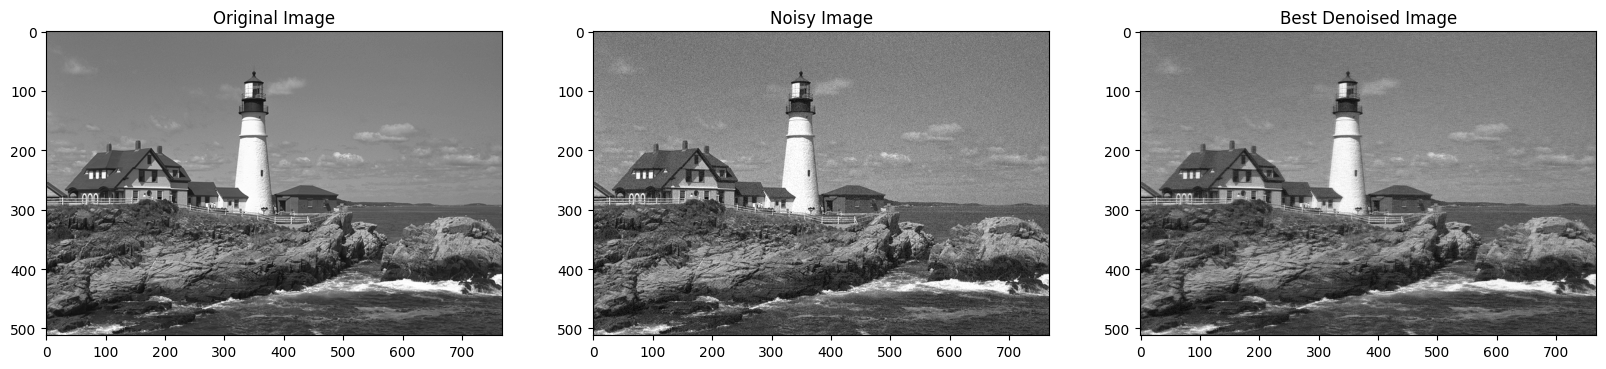

Best Gaussian Filter: Size=3, Sigma=1
Mean Squared Error (MSE) with the best filter: 67.6004295939807


In [33]:
best_denoised_image_info = min(denoised_images, key=lambda x: x['mse'])
best_denoised_image = best_denoised_image_info['image']
Y_hat=best_denoised_image

plt.figure(figsize=(20, 10))


plt.subplot(1, 3, 1)
plt.imshow(X, cmap='gray')
plt.title('Original Image')


plt.subplot(1, 3, 2)
plt.imshow(Y, cmap='gray')
plt.title('Noisy Image')


plt.subplot(1, 3, 3)
plt.imshow(Y_hat, cmap='gray')
plt.title('Best Denoised Image')

plt.show()

print(f"Best Gaussian Filter: Size={best_filter['size']}, Sigma={best_filter['sigma']}")
print(f"Mean Squared Error (MSE) with the best filter: {best_mse}")

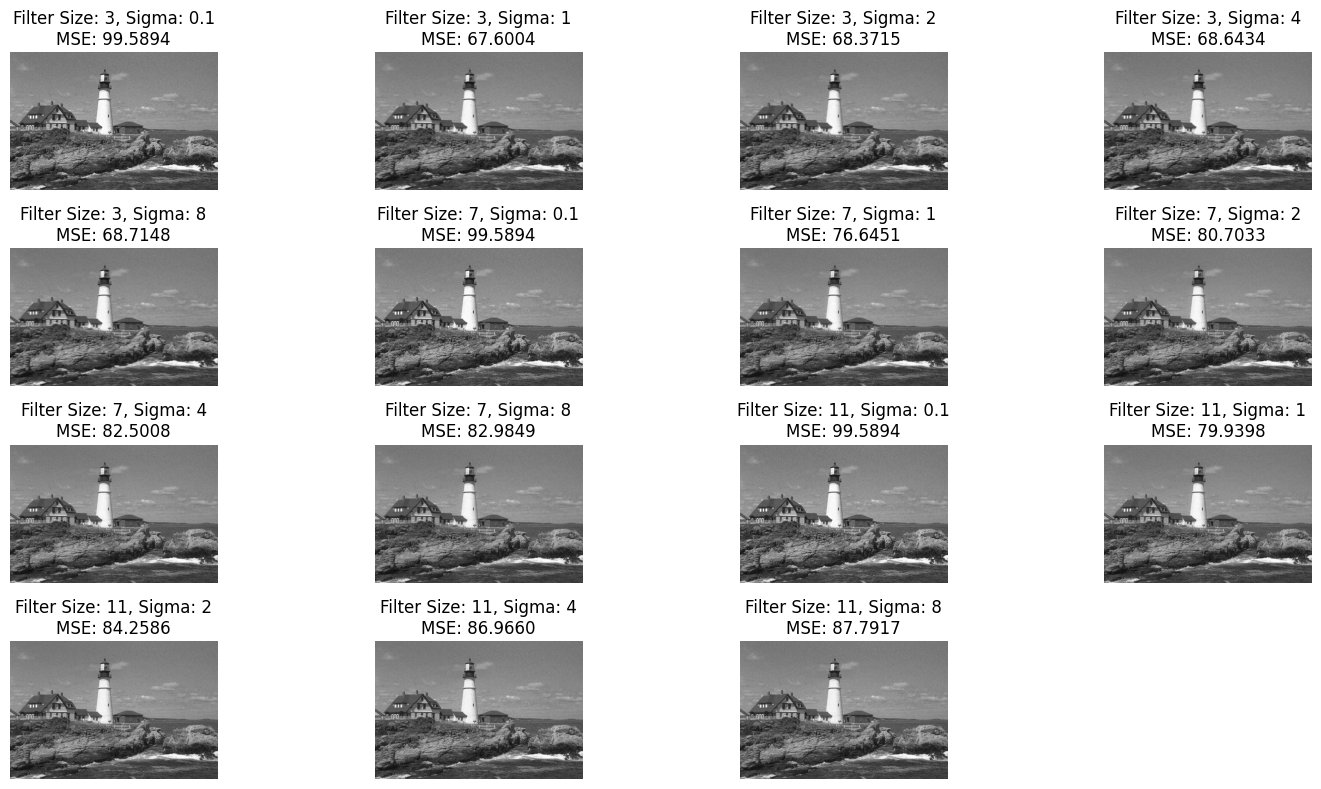

In [34]:
# Plot all denoised images
num_images = len(denoised_images)
rows = int(np.sqrt(num_images)) + 1
cols = (num_images // rows) + 1

plt.figure(figsize=(15, 8))

for i, denoised_info in enumerate(denoised_images, 1):
    plt.subplot(rows, cols, i)
    plt.imshow(denoised_info['image'], cmap='gray')
    plt.title(f"Filter Size: {denoised_info['filter_size']}, Sigma: {denoised_info['sigma']}\nMSE: {denoised_info['mse']:.4f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

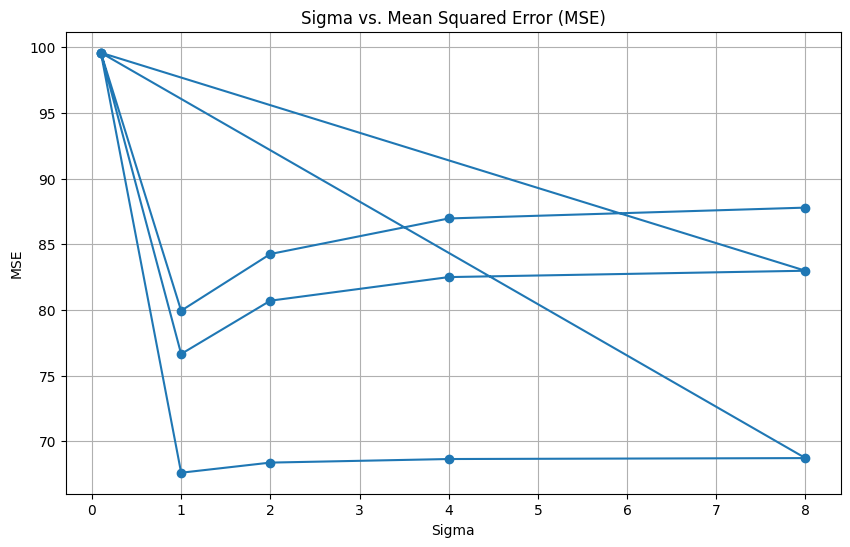

In [35]:
# Plot Sigma vs. MSE
mse_sigma = np.array(mse_sigma)
plt.figure(figsize=(10, 6))
plt.plot(mse_sigma[:, 0], mse_sigma[:, 1], marker='o', linestyle='-')
plt.title('Sigma vs. Mean Squared Error (MSE)')
plt.xlabel('Sigma')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

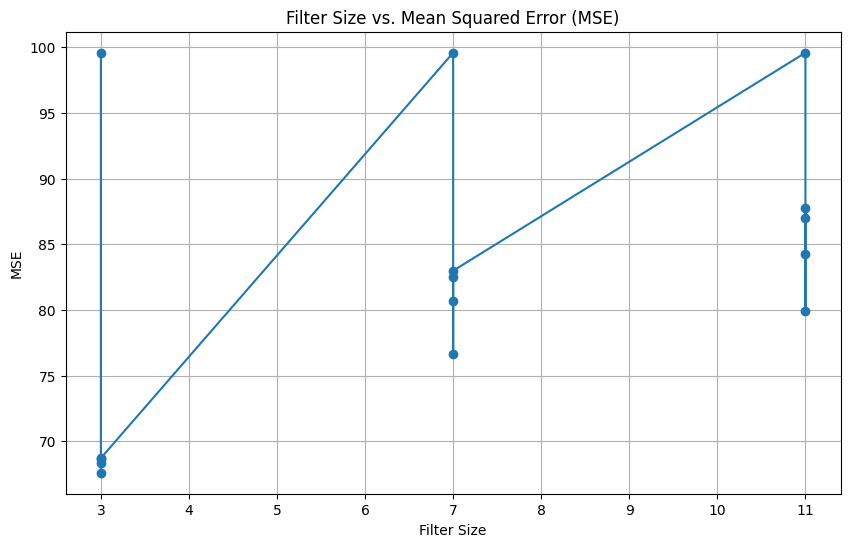

In [36]:
# Plot Filter Size vs. MSE
mse_filter = np.array(mse_filter)
plt.figure(figsize=(10, 6))
plt.plot(mse_filter[:, 0], mse_filter[:, 1], marker='o', linestyle='-')
plt.title('Filter Size vs. Mean Squared Error (MSE)')
plt.xlabel('Filter Size')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

                                                                                        2. Adaptive MMSE

In [37]:
size=3
sigma=1

In [38]:
Mu_X=apply_gaussian_filter(X,size,sigma)
Mu_Z=apply_gaussian_filter(Z,size,sigma)
Mu_Y=Mu_X + Mu_Z
respective_filter=gaussian_filter(size,sigma)
Y1=Y-Mu_Y
sigma_Y1_sq=std(Y1)

sigma_X1_sq=sigma_Y1_sq - sigma_Z1_sq
sigma_Z1_sq=calculate_coeffi(respective_filter)*100

print("variance of the high pass coefficients of the original image : ",sigma_X1_sq)
print("variance of noise in the high pass image : ",sigma_Z1_sq)

variance of the high pass coefficients of the original image :  94.20187177832693
variance of noise in the high pass image :  71.72445320530537


In [39]:
def Adaptive_MMSE_Operation(PatchImage_Y,Patch_X,Patch_Z,repeatitions):
    temp_W=np.zeros((16,16))
    Patch_Y=PatchImage_Y.copy()
    
    Patch_Mu_X=apply_gaussian_filter(Patch_X,size,sigma)
    Patch_Mu_Z=apply_gaussian_filter(Patch_Z,size,sigma)
    Patch_Mu_Y=Patch_Mu_X + Patch_Mu_Z
    
    respective_filter=gaussian_filter(size,sigma)
    Patch_Y1=Patch_Y-Patch_Mu_Y
    Patch_sigma_Y1_sq=std(Patch_Y1)
    Patch_sigma_Z1_sq=calculate_coeffi(respective_filter)*100
    Patch_sigma_X1_sq=Patch_sigma_Y1_sq - Patch_sigma_Z1_sq
    
    if(Patch_sigma_X1_sq + Patch_sigma_Z1_sq)!=0:
        t=(Patch_sigma_X1_sq/(Patch_sigma_X1_sq + Patch_sigma_Z1_sq))
    else:
        t=1
        
    for i in range(repeatitions):
        Patch_Y=Patch_Mu_Y + t * Patch_Y1
        temp_W+=Patch_Y
    temp_W/=repeatitions
    return temp_W
        

In [40]:
row=int(512/16)
col=int(768/16)
result_patch=np.zeros((16,16))
Y_cpy_mmse=Y.copy()
for i in range(row):
    for j in range(col):
        st_row=i*16
        en_row=st_row+16
        st_col=j*16
        en_col=st_col+16
        if (i==0 or i==31) and ( j==0 or j==47):
            result_patch=Adaptive_MMSE_Operation(Y_cpy_mmse[st_row:en_row,st_col:en_col],X[st_row:en_row,st_col:en_col],Z[st_row:en_row,st_col:en_col],1)

        elif i==0 or i==31 or j==0 or j== 47 :
            result_patch=Adaptive_MMSE_Operation(Y_cpy_mmse[st_row:en_row,st_col:en_col],X[st_row:en_row,st_col:en_col],Z[st_row:en_row,st_col:en_col],2)

        else:
            result_patch=Adaptive_MMSE_Operation(Y_cpy_mmse[st_row:en_row,st_col:en_col],X[st_row:en_row,st_col:en_col],Z[st_row:en_row,st_col:en_col],4)

        Y_cpy_mmse[st_row:en_row,st_col:en_col]=result_patch
    
X_hat_mmse=Y_cpy_mmse

In [41]:
X_hat_mmse

array([[ 83.93222962,  89.93568064,  99.83061052, ..., 109.53213132,
        108.47664744, 107.96110311],
       [113.42446242, 117.78676845, 119.01839504, ..., 122.57572093,
        120.2859699 , 111.70006589],
       [113.62402223, 118.28866127, 110.9692049 , ..., 117.37558659,
        111.19214058, 119.82170006],
       ...,
       [129.3069927 , 122.9127263 , 144.86931944, ...,  61.40079954,
         56.74675109,  53.27548023],
       [120.47059123, 114.10139954, 144.19821825, ...,  50.03507865,
         51.47809129,  53.95965677],
       [162.64410692, 135.70989193, 120.11189114, ...,  41.70240044,
         53.57408246,  38.66361511]])

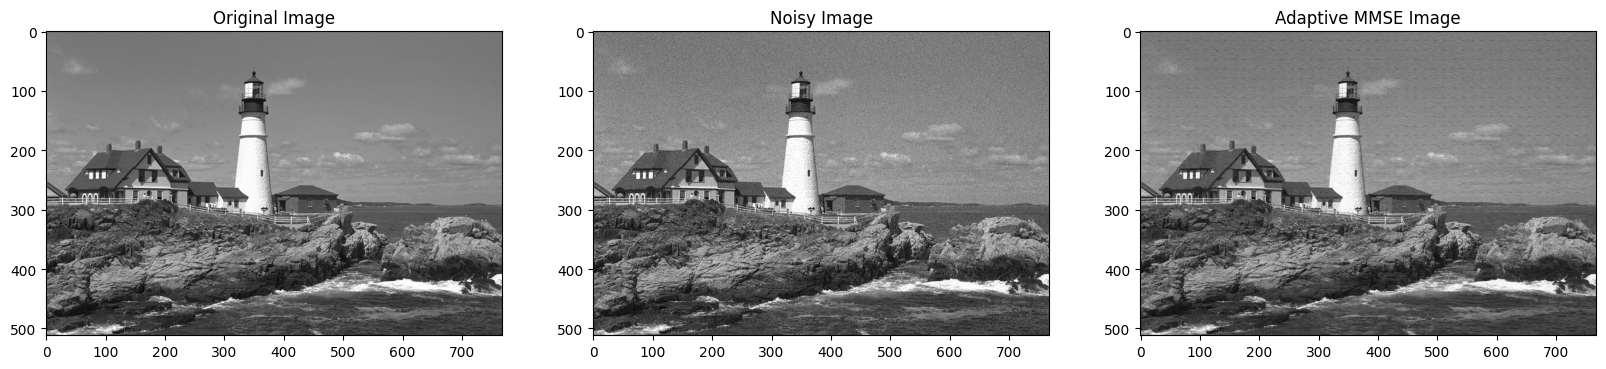

In [42]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(X, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(Y, cmap='gray')
plt.title('Noisy Image')

plt.subplot(1, 3, 3)
plt.imshow(X_hat_mmse, cmap='gray')
plt.title('Adaptive MMSE Image')

plt.show()

In [43]:
 mse_Adaptive=np.mean((X - X_hat_mmse)**2)
print("Mean Squre Error in predicting image with respect to original image in Adaptive MMSE case: ",mse_Adaptive)

Mean Squre Error in predicting image with respect to original image in Adaptive MMSE case:  61.43661123771684


                                                                                        3. Adaptive Shrinkage

In [44]:
size=3
sigma=1

In [45]:
def Adaptive_Shrinkage_Operation(PatchImage_Y ,threshold_list ):
    Patch_Y = PatchImage_Y.copy()

    # Apply Gaussian filter to obtain Mu_Y
    Mu_Y = apply_gaussian_filter(Patch_Y,size, sigma)

    # Calculate high-pass coefficients
    Patch_Y1 = Patch_Y - Mu_Y

    # Estimate robust median
    sigma_median = 0.06745 *  np.median(np.abs(Patch_Y1))

    # Calculate the threshold using SureShrink
    threshold = 2* np.log(len(Patch_Y1.flatten())) * sigma_median

    # Store the threshold value
    threshold_list.append(threshold)


    # Calculate shrinkage factor
    shrinkage_factor = -1 / 3 * threshold * sigma_median + np.sqrt((1 / 3 * threshold * sigma_median)**2 + threshold * sigma_median)

    # Apply shrinkage thresholding
    Patch_Y1_shrink = np.sign(Patch_Y1) * np.maximum(np.abs(Patch_Y1) - threshold * sigma_median, 0)

    # Reconstruct the image
    temp_W = Mu_Y + shrinkage_factor * Patch_Y1_shrink

    return temp_W


In [46]:
patch_size=32
threshold_values = []
Y_cpy_shrink = Y.copy()
row=int(512/32)
col=int(768/32)
for i in range(row):
    for j in range(col):
        st_row = i * patch_size
        en_row = st_row + patch_size
        st_col = j * patch_size
        en_col = st_col + patch_size

        result_patch = Adaptive_Shrinkage_Operation(Y_cpy_shrink[st_row:en_row, st_col:en_col] , threshold_values)

        Y_cpy_shrink[st_row:en_row, st_col:en_col] = result_patch

X_hat_Shrinkage=Y_cpy_shrink

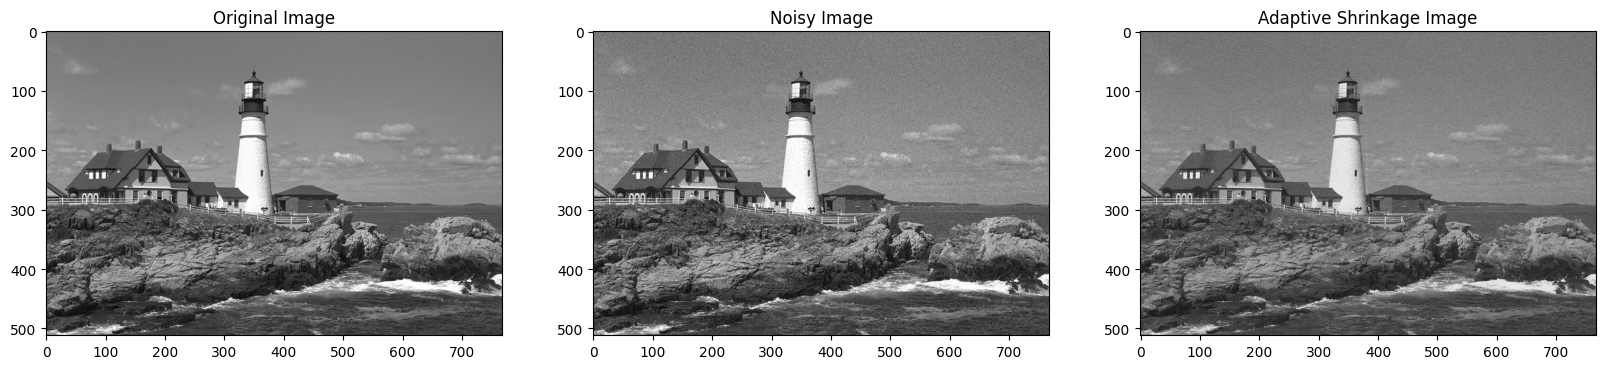

In [47]:

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(X, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(Y, cmap='gray')
plt.title('Noisy Image')

plt.subplot(1, 3, 3)
plt.imshow(X_hat_Shrinkage, cmap='gray')
plt.title('Adaptive Shrinkage Image')

plt.show()

In [48]:
mse_Shrinkage = np.mean((X - X_hat_Shrinkage)**2)
print("Mean Squared Error in predicting image with respect to the original image in Adaptive Shrinkage case:", mse_Shrinkage)

Mean Squared Error in predicting image with respect to the original image in Adaptive Shrinkage case: 78.31174257891477


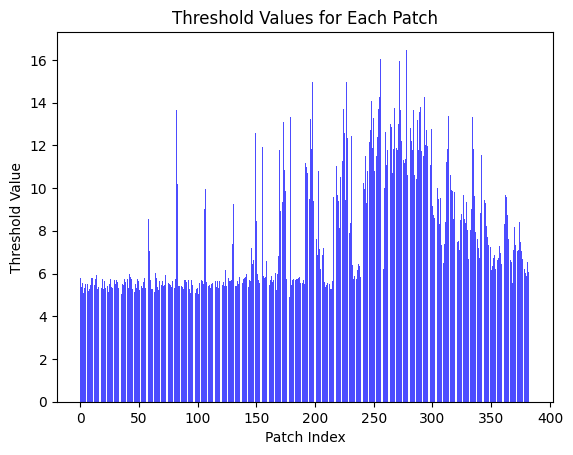

In [49]:
# Plot the threshold values as a bar plot
plt.bar(range(len(threshold_values)), threshold_values, color='blue', alpha=0.7)
plt.xlabel('Patch Index')
plt.ylabel('Threshold Value')
plt.title('Threshold Values for Each Patch')
plt.show()

                                                                                Plotting Three Denoised Image Together

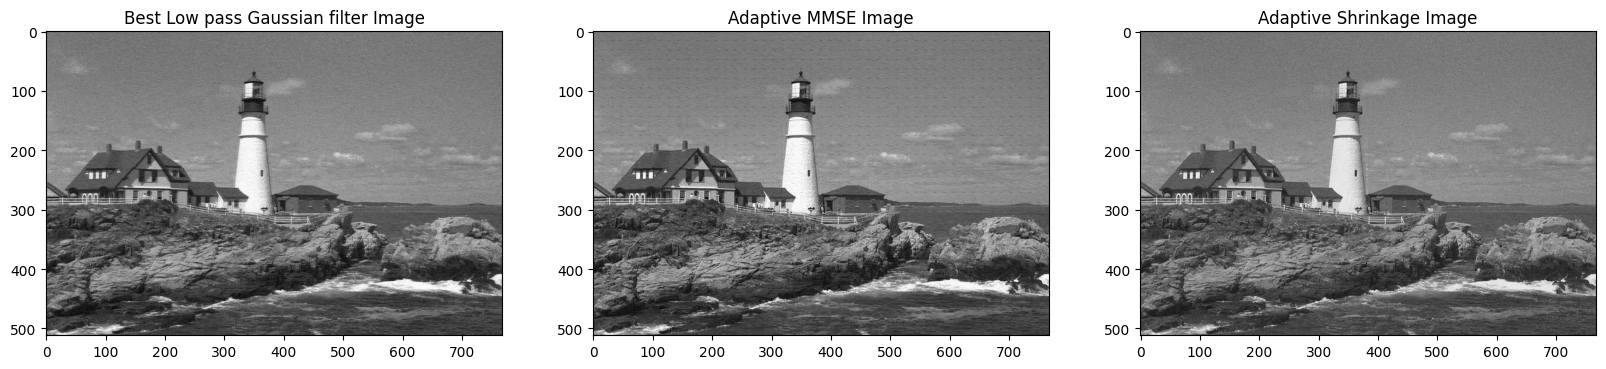

In [50]:
plt.figure(figsize=(20, 12))

plt.subplot(1, 3, 1)
plt.imshow(Y_hat, cmap='gray')
plt.title('Best Low pass Gaussian filter Image')

plt.subplot(1, 3, 2)
plt.imshow(X_hat_mmse, cmap='gray')
plt.title('Adaptive MMSE Image')

plt.subplot(1, 3, 3)
plt.imshow(X_hat_Shrinkage, cmap='gray')
plt.title('Adaptive Shrinkage Image')

plt.show()